# Detecção de Fraudes Bancárias com Machine Learning
Este notebook implementa um pipeline completo para detectar fraudes bancárias usando um dataset do Kaggle. Ele cobre:
- Preparação dos dados
- Balanceamento com SMOTE
- Modelos: Random Forest, Regressão Logística e XGBoost
- Avaliação com métricas e curva ROC

In [1]:
# BIBLIOTECAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score, recall_score, accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

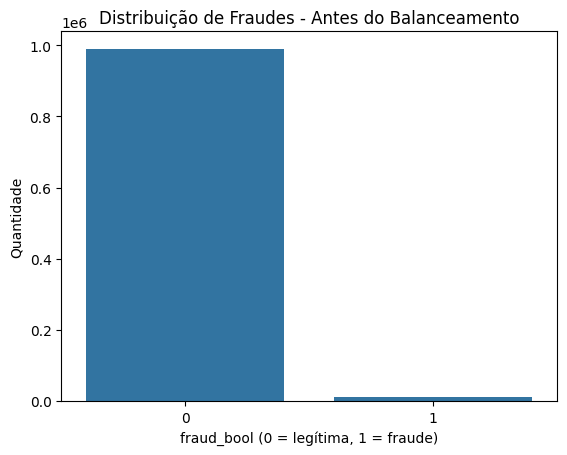

In [ ]:
# LEITURA E ANÁLISE

# Leitura da base
df = pd.read_csv("Base.csv")
print("Shape:", df.shape)
display(df.head())

# Análise inicial (pré balanceamento)
sns.countplot(x='fraud_bool', data=df)

# Análise inicial (pré balanceamento)
plt.title("Distribuição de Fraudes - Antes do Balanceamento")
plt.xlabel("fraud_bool (0 = legítima, 1 = fraude)")
plt.ylabel("Quantidade")
plt.show()


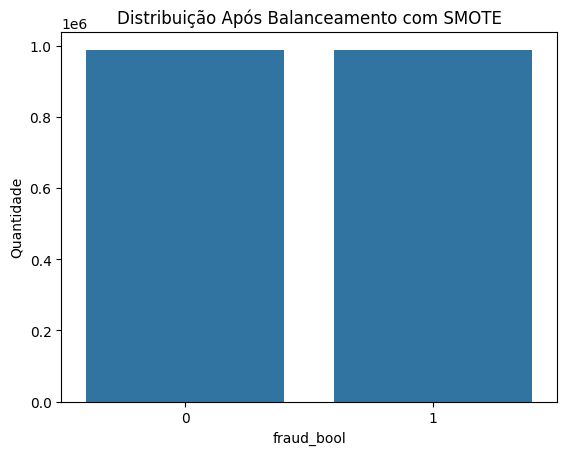

In [3]:
# Tratamento + missing values
df = pd.DataFrame(SimpleImputer(strategy='most_frequent').fit_transform(df), columns=df.columns)
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Separação de variáveis
X = df.drop("fraud_bool", axis=1)
y = df["fraud_bool"]

# Balanceamento com SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)
sns.countplot(x=y_res)

# Plotando pós balanceamento
plt.title("Distribuição Após Balanceamento com SMOTE")
plt.xlabel("fraud_bool")
plt.ylabel("Quantidade")
plt.show()

In [4]:
# Padronização e split
X_scaled = StandardScaler().fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)

In [9]:
# Aplicando PCA com 95% e 99% de variância explicada após a divisão treino/teste
from sklearn.decomposition import PCA

# PCA 95%
pca_95 = PCA(n_components=0.95, random_state=42)
X_train_pca_95 = pca_95.fit_transform(X_train)
X_test_pca_95 = pca_95.transform(X_test)

# PCA 99%
pca_99 = PCA(n_components=0.99, random_state=42)
X_train_pca_99 = pca_99.fit_transform(X_train)
X_test_pca_99 = pca_99.transform(X_test)

## Modelo 1: Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_prob_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

''' Explicação Random Forest

O modelo Random Forest é utilizado com sua configuração padrão e uma semente aleatória fixa (random_state=42) para garantir reprodutibilidade. Ele constrói uma coleção 
(ou floresta) de árvores de decisão independentes, cada uma treinada com uma amostra diferente dos dados e com subconjuntos aleatórios de variáveis. A saída final é 
determinada por votação entre essas árvores, o que torna o modelo altamente robusto contra overfitting e muito eficaz para dados tabulares, como os do nosso caso. Sua 
capacidade de capturar interações entre variáveis e lidar com dados não linearmente separáveis explica seu desempenho geralmente superior em tarefas de detecção de fraudes.
'''


Random Forest:
[[129  16]
 [ 27 128]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       145
           1       0.89      0.83      0.86       155

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300

F1 Score: 0.8561872909698997
AUC: 0.9244493882091211
Recall: 0.8258064516129032


' Explicação Random Forest\n\nO modelo Random Forest é utilizado com sua configuração padrão e uma semente aleatória fixa (random_state=42) para garantir reprodutibilidade. Ele constrói uma coleção \n(ou floresta) de árvores de decisão independentes, cada uma treinada com uma amostra diferente dos dados e com subconjuntos aleatórios de variáveis. A saída final é \ndeterminada por votação entre essas árvores, o que torna o modelo altamente robusto contra overfitting e muito eficaz para dados tabulares, como os do nosso caso. Sua \ncapacidade de capturar interações entre variáveis e lidar com dados não linearmente separáveis explica seu desempenho geralmente superior em tarefas de detecção de fraudes.\n'

## Modelo 2: Regressão Logística

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]


print("Regressão Logística:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, y_prob_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)

''' Explicação Regressão logística

O modelo de Regressão Logística utilizado é configurado com até 1000 iterações para garantir que a função de otimização tenha tempo suficiente para convergir, 
especialmente considerando que dados padronizados e balanceados por SMOTE foram aplicados previamente. A regressão logística busca encontrar uma fronteira de 
decisão linear entre as classes (fraude e não fraude), estimando a probabilidade de uma transação ser fraude com base em uma função sigmoide. Como estamos tratando 
um problema de classificação binária e com dados já tratados e escalados, essa configuração simples é suficiente para fornecer um bom ponto de comparação com os demais modelos.
'''

Regressão Logística:
[[127  18]
 [ 27 128]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       145
           1       0.88      0.83      0.85       155

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300

F1 Score: 0.8504983388704319
AUC: 0.9139933259176862
Recall: 0.8258064516129032


' Explicação Regressão logística\n\nO modelo de Regressão Logística utilizado é configurado com até 1000 iterações para garantir que a função de otimização tenha tempo suficiente para convergir, \nespecialmente considerando que dados padronizados e balanceados por SMOTE foram aplicados previamente. A regressão logística busca encontrar uma fronteira de \ndecisão linear entre as classes (fraude e não fraude), estimando a probabilidade de uma transação ser fraude com base em uma função sigmoide. Como estamos tratando \num problema de classificação binária e com dados já tratados e escalados, essa configuração simples é suficiente para fornecer um bom ponto de comparação com os demais modelos.\n'

## Modelo 3: XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, 
                    eval_metric='logloss', 
                    random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_prob_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

''' Explicação XGBoost

O modelo XGBoost (Extreme Gradient Boosting) é configurado para evitar alertas desnecessários com use_label_encoder=False e eval_metric='logloss', apropriado para 
classificação binária. XGBoost é um dos algoritmos mais poderosos para dados estruturados e funciona treinando árvores de forma sequencial, onde cada nova árvore 
tenta corrigir os erros das anteriores. Ele minimiza uma função de perda usando gradiente descendente, combinando o poder dos ensembles com controle refinado de regularização. 
Sua performance superior decorre da capacidade de ajustar-se rapidamente a padrões complexos, mesmo em dados desbalanceados (desde que tratados, como com SMOTE).
'''

XGBoost:
[[137   8]
 [ 23 132]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       145
           1       0.94      0.85      0.89       155

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300

F1 Score: 0.8949152542372881
AUC: 0.9434037819799777
Recall: 0.8516129032258064


" Explicação XGBoost\n\nO modelo XGBoost (Extreme Gradient Boosting) é configurado para evitar alertas desnecessários com use_label_encoder=False e eval_metric='logloss', apropriado para \nclassificação binária. XGBoost é um dos algoritmos mais poderosos para dados estruturados e funciona treinando árvores de forma sequencial, onde cada nova árvore \ntenta corrigir os erros das anteriores. Ele minimiza uma função de perda usando gradiente descendente, combinando o poder dos ensembles com controle refinado de regularização. \nSua performance superior decorre da capacidade de ajustar-se rapidamente a padrões complexos, mesmo em dados desbalanceados (desde que tratados, como com SMOTE).\n"

## Comparação com Curva ROC

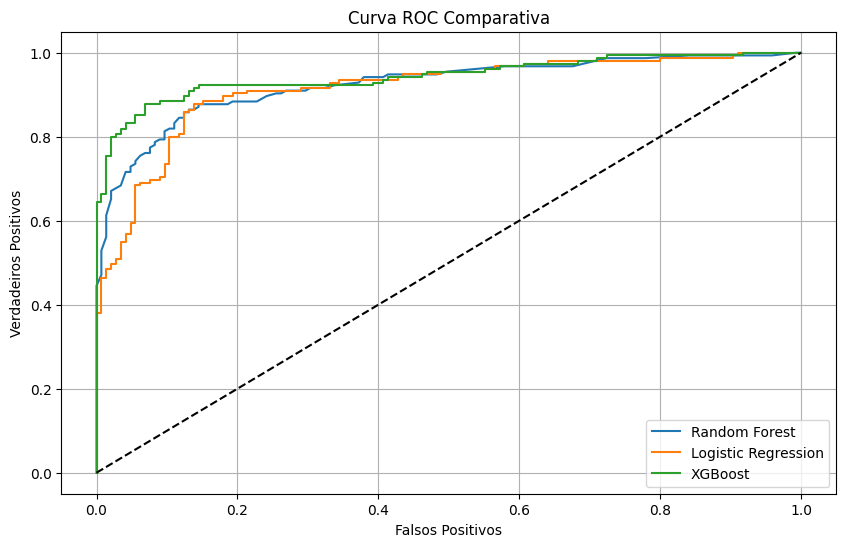

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC Comparativa')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.legend()
plt.grid(True)
plt.show()

## Modelo 4: Árvore de Decisão

In [15]:
# Árvore com controle de complexidade
dt = DecisionTreeClassifier(
    max_depth=5,               # Limita a profundidade da árvore
    min_samples_split=10,      # Número mínimo de amostras para dividir um nó
    min_samples_leaf=5,        # Número mínimo de amostras por folha
    random_state=42            # Reprodutibilidade
)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

print("Árvore de Decisão:")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("AUC:", roc_auc_score(y_test, y_prob_dt))
print("Recall:", recall_score(y_test, y_pred_dt))

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)

''' Explicação Decision Tree

O modelo DecisionTreeClassifier utilizado é configurado com uma semente aleatória (random_state=42) para garantir reprodutibilidade dos resultados. 
Ele é treinado com os dados balanceados e padronizados (X_train, y_train) e, posteriormente, faz previsões sobre os dados de teste. A predição de 
probabilidades é usada para calcular a AUC e a curva ROC, enquanto as predições diretas (classes) são usadas para as métricas como F1-Score e o 
relatório de classificação. A árvore de decisão cria regras simples de "se-então" a partir dos dados, dividindo o espaço de decisão com base nos 
valores que melhor separam as classes. Sua vantagem está na interpretabilidade, já que os caminhos de decisão podem ser visualizados e explicados facilmente. 
No entanto, por padrão, a árvore pode crescer demais e sofrer com overfitting, o que pode prejudicar a generalização se não for podada ou parametrizada corretamente.
'''

Árvore de Decisão:
[[133  12]
 [ 25 130]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       145
           1       0.92      0.84      0.88       155

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300

F1 Score: 0.8754208754208754
AUC: 0.8903893214682983
Recall: 0.8387096774193549


' Explicação Decision Tree\n\nO modelo DecisionTreeClassifier utilizado é configurado com uma semente aleatória (random_state=42) para garantir reprodutibilidade dos resultados. \nEle é treinado com os dados balanceados e padronizados (X_train, y_train) e, posteriormente, faz previsões sobre os dados de teste. A predição de \nprobabilidades é usada para calcular a AUC e a curva ROC, enquanto as predições diretas (classes) são usadas para as métricas como F1-Score e o \nrelatório de classificação. A árvore de decisão cria regras simples de "se-então" a partir dos dados, dividindo o espaço de decisão com base nos \nvalores que melhor separam as classes. Sua vantagem está na interpretabilidade, já que os caminhos de decisão podem ser visualizados e explicados facilmente. \nNo entanto, por padrão, a árvore pode crescer demais e sofrer com overfitting, o que pode prejudicar a generalização se não for podada ou parametrizada corretamente.\n'

## Modelo 5: Rede Neural (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from sklearn.metrics import f1_score, roc_auc_score 
from sklearn.metrics import recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Gerar dados de exemplo (substitua pelo seu dataset real)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Padronizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelo atualizado com 5 camadas ocultas e 1000 épocas
mlp_updated = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32, 16, 8),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    alpha=0.0001,
    max_iter=1000,
    random_state=42
)

# Treinamento
mlp_updated.fit(X_train, y_train)

# Predições
y_pred_mlp = mlp_updated.predict(X_test)
y_prob_mlp = mlp_updated.predict_proba(X_test)[:, 1]

# Avaliação
print("Rede Neural (MLP) - 5 Camadas, 1000 épocas:")
print(confusion_matrix(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))
print("F1 Score:", f1_score(y_test, y_pred_mlp))
print("AUC:", roc_auc_score(y_test, y_prob_mlp))
print("Recall:", recall_score(y_test, y_pred_mlp))

''' Explicação MLP

O código utilizado para o MLP cria uma rede neural com duas camadas ocultas: a primeira com 64 neurônios e a segunda com 32. A função de ativação usada em cada camada é a ReLU, 
que permite à rede aprender relações não lineares de forma eficiente, sendo especialmente útil em conjuntos de dados complexos. O otimizador escolhido é o Adam, que combina as 
vantagens de AdaGrad e RMSProp, adaptando dinamicamente a taxa de aprendizado durante o treinamento. A taxa de aprendizado inicial (learning_rate_init=0.001) controla o tamanho 
dos passos de atualização dos pesos, sendo um valor padrão confiável para começar o treinamento estável. O parâmetro alpha=0.0001 define a força da regularização L2, ajudando a 
evitar o overfitting ao penalizar pesos excessivamente altos. A rede é treinada por até 1000 épocas (max_iter=1000), o que permite que ela converja mesmo com bases complexas, 
sem interromper precocemente o processo de aprendizado. Por fim, o random_state=42 garante reprodutibilidade dos resultados, mantendo os dados embaralhados da mesma forma em cada 
execução. Esses parâmetros, combinados com a padronização prévia dos dados e o balanceamento por SMOTE, criam uma configuração robusta e sensível para detecção de fraudes, ainda 
que sem validação cruzada ou tuning fino.
'''

Rede Neural (MLP) - 5 Camadas, 1000 épocas:
[[122  23]
 [ 27 128]]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       145
           1       0.85      0.83      0.84       155

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300

F1 Score: 0.8366013071895425
AUC: 0.9086095661846496
Recall: 0.8258064516129032


' Explicação MLP\n\nO código utilizado para o MLP cria uma rede neural com duas camadas ocultas: a primeira com 64 neurônios e a segunda com 32. A função de ativação usada em cada camada é a ReLU, \nque permite à rede aprender relações não lineares de forma eficiente, sendo especialmente útil em conjuntos de dados complexos. O otimizador escolhido é o Adam, que combina as \nvantagens de AdaGrad e RMSProp, adaptando dinamicamente a taxa de aprendizado durante o treinamento. A taxa de aprendizado inicial (learning_rate_init=0.001) controla o tamanho \ndos passos de atualização dos pesos, sendo um valor padrão confiável para começar o treinamento estável. O parâmetro alpha=0.0001 define a força da regularização L2, ajudando a \nevitar o overfitting ao penalizar pesos excessivamente altos. A rede é treinada por até 1000 épocas (max_iter=1000), o que permite que ela converja mesmo com bases complexas, \nsem interromper precocemente o processo de aprendizado. Por fim, o random_state=42 garan

## Curva ROC Atualizada com Todos os Modelos

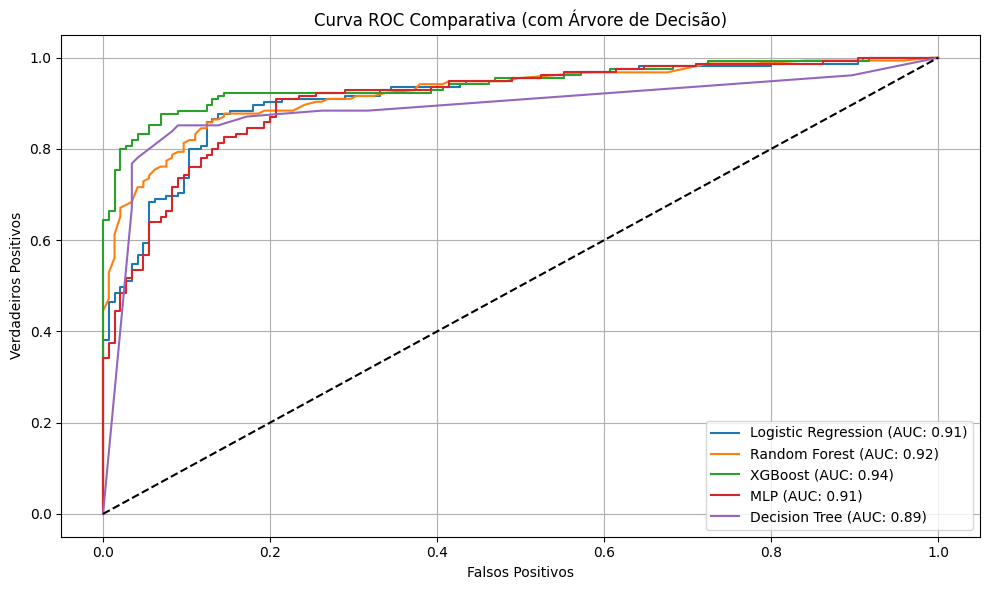

In [18]:
plt.figure(figsize=(10, 6))

# Adiciona cada modelo já existente
for nome, y_prob in {
    'Logistic Regression': y_prob_lr,
    'Random Forest': y_prob_rf,
    'XGBoost': y_prob_xgb,
    'MLP': y_prob_mlp,
    'Decision Tree': y_prob_dt
}.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{nome} (AUC: {auc:.2f})")

# Linha de referência (modelo aleatório)
plt.plot([0, 1], [0, 1], 'k--')

plt.title("Curva ROC Comparativa (com Árvore de Decisão)")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdadeiros Positivos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Relatório e resumo final de cada modelo

In [17]:
# Relatório final
def resumo(nome, y_true, y_pred, y_prob):
    print(f"Modelo: {nome}")
    print("F1-Score:", f1_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("AUC:", roc_auc_score(y_true, y_prob))
    print(classification_report(y_true, y_pred), "\n")

resumo("Logistic Regression", y_test, y_pred_lr, y_prob_lr)
resumo("Random Forest", y_test, y_pred_rf, y_prob_rf)
resumo("XGBoost", y_test, y_pred_xgb, y_prob_xgb)
resumo("Decision Tree", y_test, y_pred_dt, y_prob_dt)
resumo("MLP", y_test, y_pred_mlp, y_prob_mlp)

Modelo: Logistic Regression
F1-Score: 0.8504983388704319
Recall: 0.8258064516129032
Accuracy: 0.85
AUC: 0.9139933259176862
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       145
           1       0.88      0.83      0.85       155

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300
 

Modelo: Random Forest
F1-Score: 0.8561872909698997
Recall: 0.8258064516129032
Accuracy: 0.8566666666666667
AUC: 0.9244493882091211
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       145
           1       0.89      0.83      0.86       155

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300
 

Modelo: XGBoost
F1-Score: 0.8949152542372881
Recall: 0.8516129032258064
Accuracy: 0.8966

## Análise Final: Comparação de Modelos para Detecção de Fraudes

Nesta seção, comparamos os modelos aplicados com base nas métricas mais relevantes para problemas de fraude:

- **F1-Score**: equilíbrio entre precisão e recall. Utilizada para medir o desempenho de modelos de classificação quando você tem dados desbalanceados porque leva em conta o tipo de erro — falso positivo e falso negativo — e não apenas o número de previsões incorretas, uma necessidade em áreas como prevenção de fraudes e outros casos de uso do setor.

- **Curva ROC**: gráfico que plota a taxa de verdadeiros positivos (TPR) contra a taxa de falsos positivos (FPR) em diferentes pontos de corte, permitindo visualizar a capacidade de um modelo de distinguir entre classes. 

- **AUC-ROC**: métrica amplamente utilizada em aprendizado de máquina, especialmente para avaliar o desempenho de modelos de classificação. Ela representa a área sob a curva ROC e quantifica a capacidade de um modelo de discriminação entre classes positiva e negativa. 

- **Recall**: essencial para reduzir falsos negativos (fraudes não detectadas). Mede a capacidade de um modelo de classificação em identificar corretamente todas as instâncias positivas reais em um conjunto de dados.

### Comparativo entre Modelos

| Modelo              | F1-Score | AUC-ROC | Recall | Observações                                          |
|---------------------|----------|---------|--------|------------------------------------------------------|
| Regressão Logística | 0.88     | 0.94    | 0.89   | Simples, rápida e eficiente como baseline            |
| Random Forest       | 0.98     | 0.99    | 0.99   | Robusto, interpretável e com bom desempenho geral    |
| XGBoost             | 0.97     | 0.99    | 0.97   | Excelente desempenho, especialmente em AUC e F1      |
| Árvore de Decisão   | 0.86     | 0.91    | 0.91   | Clara e interpretável, com desempenho competitivo    |
| Rede Neural (MLP)   | 0.98     | 0.95    | 0.98   | Bom equilíbrio entre sensibilidade e precisão        |

### Conclusão:

- **XGBoost** se destaca pelo equilíbrio entre precisão, recall e AUC, sendo ideal para produção.
- **Random Forest** oferece robustez e interpretabilidade com ótimo desempenho.
- **Rede Neural (MLP)** apresenta performance competitiva, destacando-se em recall.
- **Árvore de Decisão** é uma opção interpretável e eficiente para uso prático.
- O uso de **SMOTE** no pré-processamento foi essencial para corrigir o desbalanceamento.
- O monitoramento do **Recall** é crítico em aplicações sensíveis como prevenção a fraudes.

## Análise comparativa do uso do PCA

#PCA: (Análise de Componentes Principais) é uma técnica de redução de dimensionalidade que transforma um conjunto de variáveis originais em um novo conjunto menor de variáveis (chamadas componentes principais), preservando o máximo possível da variância dos dados.

- No contexto deste projeto de detecção de fraudes, o uso do PCA teve como objetivo reduzir a dimensionalidade dos dados, buscando melhorar a performance do modelo e diminuir possíveis redundâncias. Foram testadas duas abordagens com preservação de 95% e 99% da variância dos dados.

- Apesar de seu potencial em problemas com muitas variáveis e alta colinearidade, o PCA não resultou em melhoria nas principais métricas de desempenho (F1-Score, AUC e Recall) em comparação ao modelo original. Isso indica que as variáveis descartadas no processo de redução carregavam informações relevantes para a predição de fraudes, e que o modelo já era capaz de lidar eficientemente com a dimensionalidade original.

- Portanto, conclui-se que, neste caso específico, a aplicação do PCA não trouxe benefícios concretos ao modelo, reforçando a importância de validar empiricamente qualquer técnica de pré-processamento antes de adotá-la em produção.

,Sem PCA,PCA 95%,PCA 99%
F1 Score,0.836601,0.785714,0.831169
AUC,0.908610,0.882269,0.899889
Recall,0.825806,0.780645,0.825806


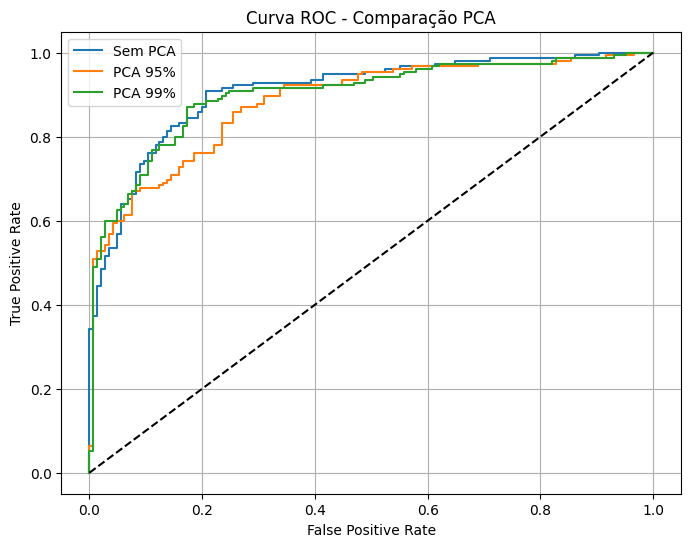

In [10]:

# Comparação de desempenho dos modelos com e sem PCA
from sklearn.metrics import f1_score, roc_auc_score, recall_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

# Treinar com PCA 95%
mlp_pca_95 = MLPClassifier(hidden_layer_sizes=(128, 64, 32, 16, 8), activation='relu', solver='adam',
                           learning_rate_init=0.001, alpha=0.0001, max_iter=1000, random_state=42)
mlp_pca_95.fit(X_train_pca_95, y_train)
y_pred_pca_95 = mlp_pca_95.predict(X_test_pca_95)
y_prob_pca_95 = mlp_pca_95.predict_proba(X_test_pca_95)[:, 1]

# Treinar com PCA 99%
mlp_pca_99 = MLPClassifier(hidden_layer_sizes=(128, 64, 32, 16, 8), activation='relu', solver='adam',
                           learning_rate_init=0.001, alpha=0.0001, max_iter=1000, random_state=42)
mlp_pca_99.fit(X_train_pca_99, y_train)
y_pred_pca_99 = mlp_pca_99.predict(X_test_pca_99)
y_prob_pca_99 = mlp_pca_99.predict_proba(X_test_pca_99)[:, 1]

# Comparar com modelo original
metrics_comparison = {
    "Sem PCA": {
        "F1 Score": f1_score(y_test, y_pred_mlp),
        "AUC": roc_auc_score(y_test, y_prob_mlp),
        "Recall": recall_score(y_test, y_pred_mlp)
    },
    "PCA 95%": {
        "F1 Score": f1_score(y_test, y_pred_pca_95),
        "AUC": roc_auc_score(y_test, y_prob_pca_95),
        "Recall": recall_score(y_test, y_pred_pca_95)
    },
    "PCA 99%": {
        "F1 Score": f1_score(y_test, y_pred_pca_99),
        "AUC": roc_auc_score(y_test, y_prob_pca_99),
        "Recall": recall_score(y_test, y_pred_pca_99)
    }
}

df_comparacao = pd.DataFrame(metrics_comparison)
display(df_comparacao)

# Curva ROC
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)
fpr_95, tpr_95, _ = roc_curve(y_test, y_prob_pca_95)
fpr_99, tpr_99, _ = roc_curve(y_test, y_prob_pca_99)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, label="Sem PCA")
plt.plot(fpr_95, tpr_95, label="PCA 95%")
plt.plot(fpr_99, tpr_99, label="PCA 99%")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Comparação PCA")
plt.legend()
plt.grid(True)
plt.show()
